<a href="https://colab.research.google.com/github/amitsinghpgs/boilerplate-advancednode/blob/master/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

# tfds.disable_progress_bar()

In [2]:
!python --version

Python 3.7.15


In [3]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteRXZ95O/imdb_reviews-train.tfrecord*...…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteRXZ95O/imdb_reviews-test.tfrecord*...:…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteRXZ95O/imdb_reviews-unsupervised.tfrec…

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [5]:
for example, label in train_dataset.take(2):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0
text:  b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. 

In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"I found 'Still Crazy' to be marvelously entertaining, and not only to those of us who lived through that raucous era of late '60s, early '70s rock. My 15 year old daughter watches it with me every time I drag out the DVD (don't worry, it's only been three times) and she loves it too.<br /><br />It is a truly loving, poignant and hilarious nod to the era, and every actor hits his/her notes with perfection. It was my first introduction to Bill Nighy and I am glad his somewhat similar turn in 'Love Actually' brought him more attention. Bruce Robinson was incredible as Brian, bringing real life to what could have been a caricature of the drug-damaged rocker stereotype. It was interesting to see that Robinson has made quite a name for himself as a writer.<br /><br />I live in Sherman Oaks, California, and after the first time I saw the movie I bumped into Billy Connolly at the local mall (he lived here at the time) and told him it was one of my five favorite films of all time. He

In [9]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [11]:
encoded_example = encoder(example)[4:30].numpy()
encoded_example

array([[ 15,  10, 237, ...,   0,   0,   0],
       [107,   2,   1, ...,   0,   0,   0],
       [121, 253, 118, ...,   0,   0,   0],
       ...,
       [ 11,  20,  14, ...,   0,   0,   0],
       [ 56, 318,   3, ...,   0,   0,   0],
       [ 10, 731,   1, ...,   0,   0,   0]])

In [12]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"I found 'Still Crazy' to be marvelously entertaining, and not only to those of us who lived through that raucous era of late '60s, early '70s rock. My 15 year old daughter watches it with me every time I drag out the DVD (don't worry, it's only been three times) and she loves it too.<br /><br />It is a truly loving, poignant and hilarious nod to the era, and every actor hits his/her notes with perfection. It was my first introduction to Bill Nighy and I am glad his somewhat similar turn in 'Love Actually' brought him more attention. Bruce Robinson was incredible as Brian, bringing real life to what could have been a caricature of the drug-damaged rocker stereotype. It was interesting to see that Robinson has made quite a name for himself as a writer.<br /><br />I live in Sherman Oaks, California, and after the first time I saw the movie I bumped into Billy Connolly at the local mall (he lived here at the time) and told him it was one of my five favorite films of all time. 

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [15]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [16]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 44s 83ms/step - loss: 0.6364 - accuracy: 0.5788 - val_loss: 0.5014 - val_accuracy: 0.7667
Epoch 2/10
391/391 [==============================] - 31s 80ms/step - loss: 0.4391 - accuracy: 0.7938 - val_loss: 0.3970 - val_accuracy: 0.8135
Epoch 3/10
391/391 [==============================] - 30s 77ms/step - loss: 0.3784 - accuracy: 0.8291 - val_loss: 0.3703 - val_accuracy: 0.8375
Epoch 4/10
391/391 [==============================] - 30s 77ms/step - loss: 0.3430 - accuracy: 0.8497 - val_loss: 0.3471 - val_accuracy: 0.8479
Epoch 5/10
391/391 [==============================] - 30s 77ms/step - loss: 0.3245 - accuracy: 0.8604 - val_loss: 0.3398 - val_accuracy: 0.8516
Epoch 6/10
391/391 [==============================] - 30s 76ms/step - loss: 0.3162 - accuracy: 0.8664 - val_loss: 0.3364 - val_accuracy: 0.8479
Epoch 7/10
391/391 [==============================] - 31s 78ms/step - loss: 0.3075 - accuracy: 0.8670 - val_loss: 0.3261 - val_accuracy:

In [17]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 19s 48ms/step - loss: 0.3285 - accuracy: 0.8387
Test Loss: 0.32851120829582214
Test Accuracy: 0.8386800289154053


(0.0, 0.6533346086740494)

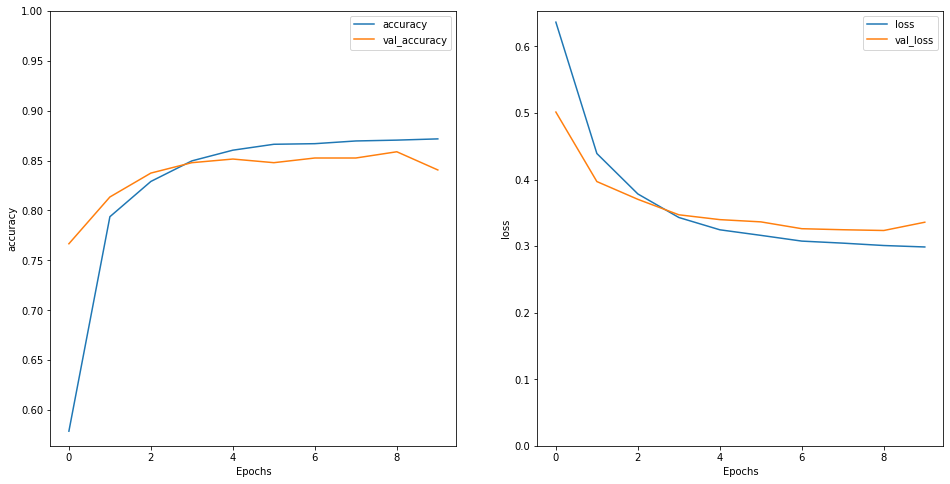

In [18]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [20]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
predictions

1/1 [==============================] - 0s 18ms/step


array([[0.7798337]], dtype=float32)

In [21]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [22]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [23]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 74s 151ms/step - loss: 0.6166 - accuracy: 0.6020 - val_loss: 0.4299 - val_accuracy: 0.8005
Epoch 2/10
391/391 [==============================] - 52s 133ms/step - loss: 0.3784 - accuracy: 0.8373 - val_loss: 0.3501 - val_accuracy: 0.8448
Epoch 3/10
391/391 [==============================] - 51s 129ms/step - loss: 0.3336 - accuracy: 0.8588 - val_loss: 0.3472 - val_accuracy: 0.8531
Epoch 4/10
391/391 [==============================] - 51s 130ms/step - loss: 0.3214 - accuracy: 0.8632 - val_loss: 0.3282 - val_accuracy: 0.8589
Epoch 5/10
391/391 [==============================] - 53s 135ms/step - loss: 0.3108 - accuracy: 0.8677 - val_loss: 0.3270 - val_accuracy: 0.8552
Epoch 6/10
391/391 [==============================] - 53s 136ms/step - loss: 0.3072 - accuracy: 0.8698 - val_loss: 0.3164 - val_accuracy: 0.8557
Epoch 7/10
391/391 [==============================] - 53s 136ms/step - loss: 0.3011 - accuracy: 0.8701 - val_loss: 0.3208 - val_ac

In [24]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 28s 71ms/step - loss: 0.3180 - accuracy: 0.8609
Test Loss: 0.3179854452610016
Test Accuracy: 0.8609200119972229


In [25]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 5s 5s/step
[[-1.6263313]]
